# Rag with LangChain



Using a example pdf, we are going to store in a vectorestore  and use it on the RAG

## Creating the infraestructure

- Getting the pdf
- Storing in a vectorstore
- Generating a retriever



In [49]:
from langchain.document_loaders import PyPDFLoader


In [50]:
#Get the pdf
pdf_file_path = "my_pdf.pdf"

pdf_file = PyPDFLoader(pdf_file_path)
docs = pdf_file.load()



In [51]:
docs

[Document(metadata={'producer': 'macOS Version 15.5 (Build 24F74) Quartz PDFContext', 'creator': 'Preview', 'creationdate': "D:20250804162618Z00'00'", 'title': 'C1_PhrasalVerbs', 'moddate': "D:20250804162618Z00'00'", 'source': 'my_pdf.pdf', 'total_pages': 6, 'page': 0, 'page_label': '1'}, page_content=''),
 Document(metadata={'producer': 'macOS Version 15.5 (Build 24F74) Quartz PDFContext', 'creator': 'Preview', 'creationdate': "D:20250804162618Z00'00'", 'title': 'C1_PhrasalVerbs', 'moddate': "D:20250804162618Z00'00'", 'source': 'my_pdf.pdf', 'total_pages': 6, 'page': 1, 'page_label': '2'}, page_content=''),
 Document(metadata={'producer': 'macOS Version 15.5 (Build 24F74) Quartz PDFContext', 'creator': 'Preview', 'creationdate': "D:20250804162618Z00'00'", 'title': 'C1_PhrasalVerbs', 'moddate': "D:20250804162618Z00'00'", 'source': 'my_pdf.pdf', 'total_pages': 6, 'page': 2, 'page_label': '3'}, page_content=''),
 Document(metadata={'producer': 'macOS Version 15.5 (Build 24F74) Quartz PDF

In [52]:
len(docs[0].page_content)

0

In [53]:
#The pdf contains images, we are going to use UnstructuredLoader
from langchain_unstructured import UnstructuredLoader


To use Unstructured parsing LOCALLY, we need to next dependencies:

Local parsing

Parsing locally requires the installation of additional dependencies.

Poppler (PDF analysis)

Linux: apt-get install poppler-utils
Mac: brew install poppler
Windows: https://github.com/oschwartz10612/poppler-windows
Tesseract (OCR)

Linux: apt-get install tesseract-ocr
Mac: brew install tesseract
Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows
We will also need to install the unstructured PDF extras:

%pip install -qU "unstructured[pdf]"

In [54]:
loader = UnstructuredLoader(pdf_file_path,
                            strategy="hi_res")

docs = []
for doc in loader.lazy_load():
    docs.append(doc)

INFO: Reading PDF for file: my_pdf.pdf ...


In [55]:
len(docs)

321

In [56]:
docs[6]

Document(metadata={'source': 'my_pdf.pdf', 'detection_class_prob': 0.904830276966095, 'coordinates': {'points': ((np.float64(189.44822692871094), np.float64(800.351806640625)), (np.float64(189.44822692871094), np.float64(879.6382446289062)), (np.float64(789.1942138671875), np.float64(879.6382446289062)), (np.float64(789.1942138671875), np.float64(800.351806640625))), 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}, 'last_modified': '2025-08-04T18:26:43', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'filename': 'my_pdf.pdf', 'parent_id': '10650cd204a0fc51817b1b0e7df3b632', 'category': 'ListItem', 'element_id': 'a81433a9a85bcad29001b67ab3beac2b'}, page_content="back up give support to someone by telling other people that you agree with them backup (n): | didn’t believe Simon's story until Janice backed him up.")

It's not necessary to chunk the content, is not to large, otherwise we should do it in smaller chunks

In [57]:
#Using Ollama_embeding to generate the embedings

from langchain_ollama import OllamaEmbeddings, ChatOllama

embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [58]:
#Storing the embedings in langchain_vectorstore "Chroma"
#need pip install chromadb
from langchain_community.vectorstores import Chroma

from langchain_community.vectorstores.utils import filter_complex_metadata
#documents has complex data, coordinates, where are going to use filter_complex_metadata to solve this issue, to quit this key from metadata

vectorstore = Chroma.from_documents(
    documents=filter_complex_metadata(docs),
    embedding= embeddings,
    persist_directory="chroma_store"
)

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [59]:
#Creating a retriever to vectorstore
retriever = vectorstore.as_retriever() #We are going to use default values


In [60]:
question = "Meaning of back up verb"

retriever.invoke(question)

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


[Document(metadata={'element_id': 'c09c9598bc80770db8cb578dea5fc825', 'page_number': 1, 'filetype': 'application/pdf', 'source': 'my_pdf.pdf', 'detection_class_prob': 0.8957679867744446, 'parent_id': '10650cd204a0fc51817b1b0e7df3b632', 'last_modified': '2025-08-04T18:26:43', 'filename': 'my_pdf.pdf', 'category': 'ListItem'}, page_content='back up make a copy of information on your computer backup (n): Make sure you back al! your data up, just in case you get a virus.'),
 Document(metadata={'last_modified': '2025-08-04T18:26:43', 'page_number': 1, 'parent_id': '10650cd204a0fc51817b1b0e7df3b632', 'detection_class_prob': 0.8957679867744446, 'element_id': 'c09c9598bc80770db8cb578dea5fc825', 'category': 'ListItem', 'source': 'my_pdf.pdf', 'filename': 'my_pdf.pdf', 'filetype': 'application/pdf'}, page_content='back up make a copy of information on your computer backup (n): Make sure you back al! your data up, just in case you get a virus.'),
 Document(metadata={'element_id': 'c09c9598bc80770

## Generating the RAG

In [61]:
ollama_model = "qwen2.5:7b"

llm = ChatOllama(model=ollama_model)

In [62]:
from langchain_core.prompts import PromptTemplate

#We are going to define the prompt template for our RAG
template="""
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to find the examples of the requested phrasal verbs.
If you don't know the answer, respond as "I don't know"

Question: Examples to understand the meaning of the phrasal verb {question}

Context: {context}

Answer:"""

prompt = PromptTemplate(template=template)

In [63]:
#Creating the pipeline
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
#To format the docs retrievers

#Is a pipeline, like Linu
rag_chain = (
    {"context": retriever | format_docs, "question":RunnablePassthrough()} | prompt | llm | StrOutputParser()
)


In [64]:
query="back up"
response = rag_chain.invoke(query)

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In [65]:
print(response)

Based on the context provided, here are examples of the phrasal verb "back up":

1. **Verb form:** To make a copy of information on your computer.
   - Example: Make sure you back all your data up, just in case you get a virus.

2. **Verb form:** To give support to someone by telling other people that you agree with them.
   - Example: I didn’t believe Simon's story until Janice backed him up.


In [66]:
query="fade away"
response = rag_chain.invoke(query)

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In [67]:
print(response)

Sure, here are examples that illustrate the meaning of the phrasal verb "fade away":

1. **To my amazement, the letters on the page slowly faded away.**
2. **The sound of the music began to fade away as the performance ended.**

These examples demonstrate how something gradually disappears or diminishes over time.


In [68]:
query="far away"
response = rag_chain.invoke(query)
print(response)

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


I don't know

The provided context does not contain any examples of the phrasal verb "far away." The context includes instances of "meet up" and "spread out," but not "far away." If you need examples for "far away," please let me know, and I can provide some.


# RAG With LangGraph

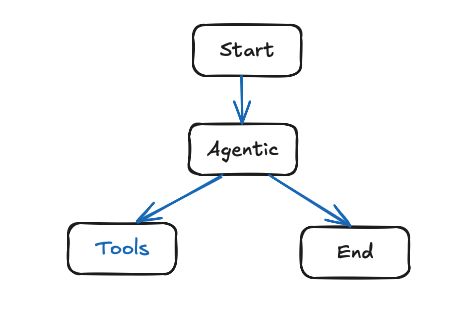

In [69]:
#Defining the tools
from langchain.tools import Tool
from langchain_community.tools import DuckDuckGoSearchRun

rag_tool = Tool(
    name="PharsalVerbsRetriever",
    func=rag_chain.invoke,
    description="Usefull for get definition and examples of English phrasal verbs provided in PDF document"
)

search_tool = Tool(
    name="DuckDuckSearch",
    func=DuckDuckGoSearchRun().invoke,
    description="Usefull for search other content or information  in the Web, not found in the document"
)

tools = [rag_tool,search_tool]

llm_with_tools = llm.bind_tools(tools)

In [70]:
from langchain_core.messages import BaseMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
import operator

# Define the state for our graph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [71]:
from langchain_core.messages import HumanMessage, SystemMessage

def assistant(state: AgentState):
    tool_descriptions = []
    for tool in tools:
        # Basic formatting, might need refinement depending on how you want to present it
        tool_descriptions.append(f"{tool.name}: {tool.description}")

    textual_description_of_tool = "\n".join(tool_descriptions)

    # Construct the system message using the generated tool descriptions
    sys_msg_content = (
        f"You are a helpful assistant. You have access to the following tools:\n"
        f"{textual_description_of_tool}\n\n"
        f"Please respond to the user's request."
    )
    sys_msg = SystemMessage(content=sys_msg_content)

    return {
            "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
    }

In [72]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

# Graph builder
builder = StateGraph(AgentState)

builder.add_node(
    "assistant",
    assistant,
)

builder.add_node(
    "tools", ToolNode(tools)
)

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

In [73]:
react_graph = builder.compile()

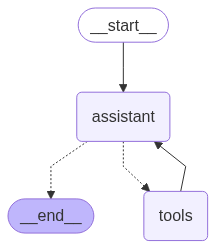

In [74]:
react_graph

In [ ]:
messages = [HumanMessage(content="back up")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


================================ Human Message =================================

back up
================================== Ai Message ==================================
Tool Calls:
  PharsalVerbsRetriever (50493423-31ab-434e-9d0e-6c7a043abd14)
 Call ID: 50493423-31ab-434e-9d0e-6c7a043abd14
  Args:
    __arg1: back up
================================= Tool Message =================================
Name: PharsalVerbsRetriever

Based on the context provided, here are examples of the phrasal verb "back up":

1. **Back up make a copy of information on your computer** - This means to create a duplicate copy of data stored in your computer, usually to prevent loss due to accidents or technical issues.
   
2. **backup (n): Make sure you back all your data up, just in case you get a virus.** - Here "back up" is used as a noun and refers to the process of creating a backup copy of data.

3. **Back up give support to someone by telling other people that you agree with them** - This means to sup

In [77]:
messages = [HumanMessage(content="Oscar a los mejores peliculas de los ultimos 10 años")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
/Users/jayarza/Developer/Projects/Resume_Projects/RAG_FirstRAG_QA/.venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
INFO: response: https://www.bing.com/search?q=Oscar+winning+best+movies+of+the+last+10+years&filters=ex1%3A%22ez5_19940_20305%22 200
INFO: response: https://www.bing.com/search?q=Oscar+winning+best+movies+of+the+last+10+years&filters=ex1%3A%22ez5_19940_20305%22&first=11&FORM=PERE 200
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
/Users/jayarza/Developer/Projects/Resume_Projects/RAG_FirstRAG_QA/.venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with D

================================ Human Message =================================

Oscar a los mejores peliculas de los ultimos 10 años
================================== Ai Message ==================================

It seems like you're asking about Oscar-winning best movies of the last 10 years. However, I don't have direct access to real-time data or current Oscar winners. Let me use DuckDuckSearch to find this information for you.
Tool Calls:
  DuckDuckSearch (0f9a6fc4-a1d7-4f8f-bd62-bd6b51addf05)
 Call ID: 0f9a6fc4-a1d7-4f8f-bd62-bd6b51addf05
  Args:
    query: Oscar winning best movies of the last 10 years
================================= Tool Message =================================
Name: DuckDuckSearch

Mar 19, 2019 · FTP站点部署好之后，可以通过多种方式访问：ftp工具、Windows资源管理器、IE浏览器三种，本文详细介 … Apr 3, 2018 · 阿里云全新升级网站 云服务器，2核2G云服务器38元火热抢购，200Mbps峰值公网带宽，快速部署。 Mar 9, 2025 · Oppenheimer, Anora, and Gladiator are among the absolute greatest Oscar Best Picture winners of the last quarter century. Apr 

## Tracing and Evaluation with Langfuse

Steps:

- Install Langfuse locally in Docker